# PHASE 2 PROJECT

## Business problem

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

# Data Description
we chose 3 data sets that give budget, revenue and film metadata which are essential to answer the business question (which film types make the most money):
 
 * `tn.movie_budget.csv` -production budgets & gross receipts. can help compute ROI,profit etc(loaded as `budgets`)

 * `tmdb.movies.csv` - movies metadata (genres,release dates,language,popularity,votes etc) (loaded as `tmdb`)
 * `bom.movies_gross.csv`-(loaded as `bom_gross`)
 * `im.db` with tables `movie_rating` and `movie_basics`

In [2152]:
#import relevant libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # optional for nicer plotting
import sqlite3

from scipy.stats import ttest_ind, ttest_1samp, chi2_contingency, norm

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
sns.set(style="whitegrid", rc={"figure.dpi":100})

#### loading the datasets

In [2153]:
# loading the datasets

budgets = pd.read_csv("../Data/tn.movie_budgets.csv", low_memory=False)
tmdb = pd.read_csv("../Data/tmdb.movies.csv", low_memory=False)
bom = pd.read_csv('../Data/bom.movie_gross.csv', low_memory=False)

# quick peek
print(budgets.shape, tmdb.shape, bom.shape)
budgets.head()

(5782, 6) (26517, 10) (3387, 5)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [2154]:
#check columns
print(budgets.columns)
print(tmdb.columns)
print(bom.columns)

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')


#### Loading the `im.db` sqlite database

In [2155]:

# Connect to the imdb-style database
conn = sqlite3.connect("../Data/im.db")

# List all tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in im.db:")
print(tables)



Tables in im.db:
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [2156]:
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics;", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings;", conn)

# Data Exploration and Cleaning

### 1. `tbmd.movies.csv` read as `tmbd`

In [2157]:
tmdb.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [2158]:
print(tmdb.columns)
print(tmdb.info())
print(tmdb.isna().sum().sort_values(ascending=False))
print(tmdb.duplicated().sum())

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB
None
Unnamed: 0           0
genre_ids            0
id                   0
o

In [2159]:
# Convert release_date to datetime
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'], errors='coerce')

# Extract year
tmdb['year'] = tmdb['release_date'].dt.year

# Clean title
tmdb['title_clean'] = tmdb['title'].str.lower().str.strip()

#drop unnamed
tmdb.drop(columns=['Unnamed: 0'],inplace=True)

#drop duplicates
tmdb.drop_duplicates(inplace=True)

In [2160]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,year,title_clean
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,2010,harry potter and the deathly hallows: part 1
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,2010,how to train your dragon
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,2010,iron man 2
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,1995,toy story
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,2010,inception


In [2161]:
tmdb.duplicated().sum()

0

### 2. `tn.movie_budget.csv` read as `budgets`

In [2162]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [2163]:
print(budgets.columns)
print(budgets.info())
print(budgets.isna().sum().sort_values(ascending=False))
print(budgets.duplicated().sum())

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB
None
id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64
0


In [2164]:
# Remove dollar signs and commas
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    budgets[col] = (
        budgets[col]
        .replace('[\$,]', '', regex=True)
        .astype(float)
    )

# Convert release_date to datetime
budgets['release_date'] = pd.to_datetime(budgets['release_date'], errors='coerce')

# Extract release year
budgets['release_year'] = budgets['release_date'].dt.year

# Clean movie title (lowercase, strip spaces)
budgets['movie_clean'] = budgets['movie'].str.lower().str.strip()


In [2165]:
# Generate a `profit` column to determine net earnings by subtracting production costs from total revenues.

budgets['profit'] = budgets['worldwide_gross'] - budgets['production_budget']

In [2166]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,movie_clean,profit
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2009,avatar,2.351345e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,pirates of the caribbean: on stranger tides,6.350639e+08
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,dark phoenix,-2.002376e+08
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,avengers: age of ultron,1.072414e+09
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017,star wars ep. viii: the last jedi,9.997217e+08


### 3. `bom.movie_gross.csv` read as `bom`

In [2167]:
bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [2168]:
print(bom.columns)
print(bom.info())
print(bom.isna().sum().sort_values(ascending=False))
print(bom.duplicated().sum())


Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None
foreign_gross     1350
domestic_gross      28
studio               5
title                0
year                 0
dtype: int64
0


In [2169]:
bom.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


In [2170]:
bom['studio'].isna().sum()

5

In [2171]:
# Convert foreign_gross to numeric
bom['foreign_gross'] = pd.to_numeric(bom['foreign_gross'], errors='coerce')

# Drop rows missing both gross values
bom = bom.dropna(subset=['domestic_gross'], how='all')

# Fill missing foreign_gross with median (preserve 70%+)
median_foreign = bom['foreign_gross'].median()
bom['foreign_gross'].fillna(median_foreign, inplace=True)

# Fill missing studio with "Unknown"
bom['studio'].fillna("Unknown", inplace=True)

#change year to datetime
bom['year']=pd.to_datetime(bom['year'])

In [2172]:
bom.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

### 4. `im.db` database 

In [2173]:
#merging movie_basics and movie_ratings on movie_id
df_imdb = pd.read_sql('''SELECT *
               FROM movie_basics 
               JOIN movie_ratings 
               USING(movie_id);
            ''', conn)



In [2174]:
df_imdb['title_clean'] = df_imdb['primary_title'].str.lower().str.strip()
df_imdb['year'] = pd.to_numeric(df_imdb['start_year'], errors='coerce')

# Keep only movies (exclude TV, shorts, etc.)
#df_movies = df_movies[df_movies['title_type'] == 'movie']

In [2175]:
df_imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,year
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,sunghursh,2013
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,one day before the rainy season,2019
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,the other side of the wind,2018
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13,sabse bada sukh,2018
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119,the wandering soap opera,2017


In [2176]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
 8   title_clean      73856 non-null  object 
 9   year             73856 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 5.6+ MB


In [2177]:
#check percentage of missing values
(df_imdb.isna().sum() / len(df_imdb) * 100).sort_values(ascending=False)

runtime_minutes    10.317374
genres              1.088605
movie_id            0.000000
primary_title       0.000000
original_title      0.000000
start_year          0.000000
averagerating       0.000000
numvotes            0.000000
title_clean         0.000000
year                0.000000
dtype: float64

In [2178]:
#cleaning the merged df
#drop runtime_minutes
df_imdb = df_imdb.dropna(subset=['runtime_minutes'])


#fill missing genres with unknown to preserve data
df_imdb['genres']=df_imdb['genres'].fillna('Unknown')

In [2179]:
#recheck percentage of missing values
(df_imdb.isna().sum() / len(df_imdb) * 100).sort_values(ascending=False)

movie_id           0.0
primary_title      0.0
original_title     0.0
start_year         0.0
runtime_minutes    0.0
genres             0.0
averagerating      0.0
numvotes           0.0
title_clean        0.0
year               0.0
dtype: float64

## FEATURE ENGINEERING

merge `df_imdb` with `budgets` to create `combined_df`

In [2180]:
df_imdb.columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'title_clean',
       'year'],
      dtype='object')

In [2181]:
budgets.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'release_year', 'movie_clean', 'profit'],
      dtype='object')

In [2182]:
#merge datasets
combined_df=pd.merge(df_imdb,budgets,how='inner',left_on='primary_title',right_on='movie')
combined_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,title_clean,year,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,movie_clean,profit
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,foodfight!,2012,26,2012-12-31,Foodfight!,45000000.0,0.0,73706.0,2012,foodfight!,-44926294.0
1,tt0326592,The Overnight,The Overnight,2010,88.0,Unknown,7.5,24,the overnight,2010,21,2015-06-19,The Overnight,200000.0,1109808.0,1165996.0,2015,the overnight,965996.0
2,tt3844362,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,the overnight,2015,21,2015-06-19,The Overnight,200000.0,1109808.0,1165996.0,2015,the overnight,965996.0
3,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,on the road,2012,17,2013-03-22,On the Road,25000000.0,720828.0,9313302.0,2013,on the road,-15686698.0
4,tt4339118,On the Road,On the Road,2014,89.0,Drama,6.0,6,on the road,2014,17,2013-03-22,On the Road,25000000.0,720828.0,9313302.0,2013,on the road,-15686698.0


In [2183]:
combined_df.columns

Index(['movie_id', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres', 'averagerating', 'numvotes', 'title_clean',
       'year', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'release_year', 'movie_clean',
       'profit'],
      dtype='object')

In [2184]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2757 entries, 0 to 2756
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           2757 non-null   object        
 1   primary_title      2757 non-null   object        
 2   original_title     2757 non-null   object        
 3   start_year         2757 non-null   int64         
 4   runtime_minutes    2757 non-null   float64       
 5   genres             2757 non-null   object        
 6   averagerating      2757 non-null   float64       
 7   numvotes           2757 non-null   int64         
 8   title_clean        2757 non-null   object        
 9   year               2757 non-null   int64         
 10  id                 2757 non-null   int64         
 11  release_date       2757 non-null   datetime64[ns]
 12  movie              2757 non-null   object        
 13  production_budget  2757 non-null   float64       
 14  domestic

# EDA ANALYSIS

In [2185]:
combined_df['primary_title'].value_counts()

primary_title
Home                     24
Brothers                 12
Hamlet                   10
The Gambler              10
The Return               10
                         ..
The Age of Adaline        1
My Week with Marilyn      1
Jesse                     1
Dysfunctional Friends     1
Unplanned                 1
Name: count, Length: 2092, dtype: int64

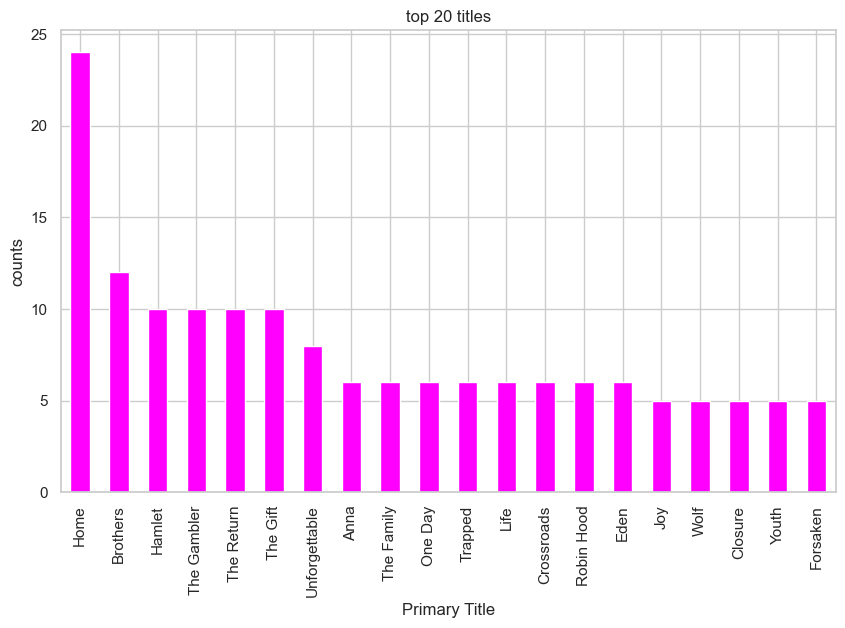

In [2186]:
#first 20 titles
combined_df['primary_title'].value_counts().head(20)

#plotting
combined_df['primary_title'].value_counts().head(20).plot(kind='bar',color='magenta')
plt.title('top 20 titles')
plt.xlabel('Primary Title')
plt.ylabel('counts')
plt.show()

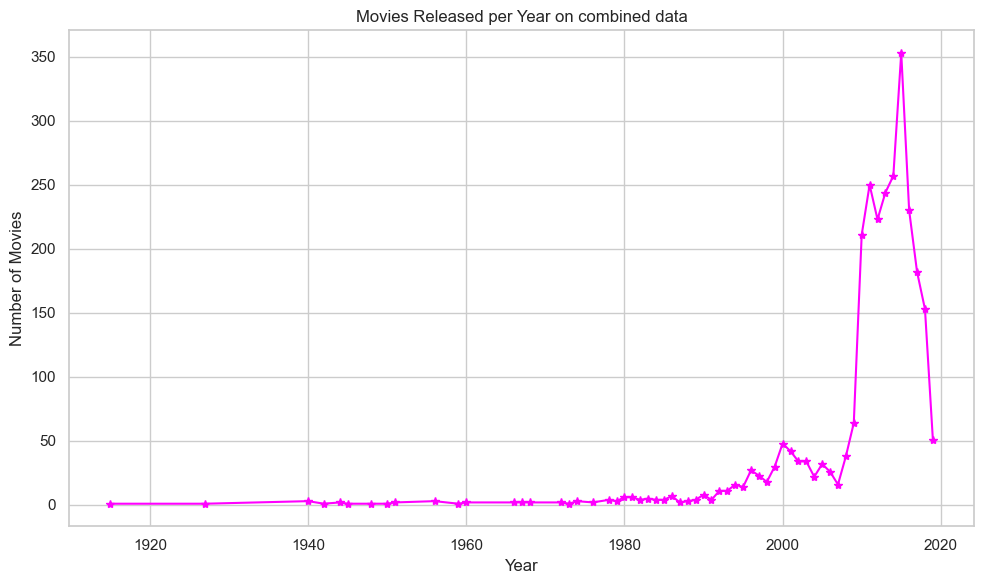

In [2187]:
combined_df['release_year'].value_counts().sort_index().plot(kind='line',marker='*',color='magenta')
plt.title('Movies Released per Year on combined data')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)

plt.tight_layout()
plt.show()

In [2188]:
print(type(combined_df['averagerating']))
print(combined_df['averagerating'].head())
print(combined_df['averagerating'].shape)


<class 'pandas.core.series.Series'>
0    1.9
1    7.5
2    6.1
3    6.1
4    6.0
Name: averagerating, dtype: float64
(2757,)


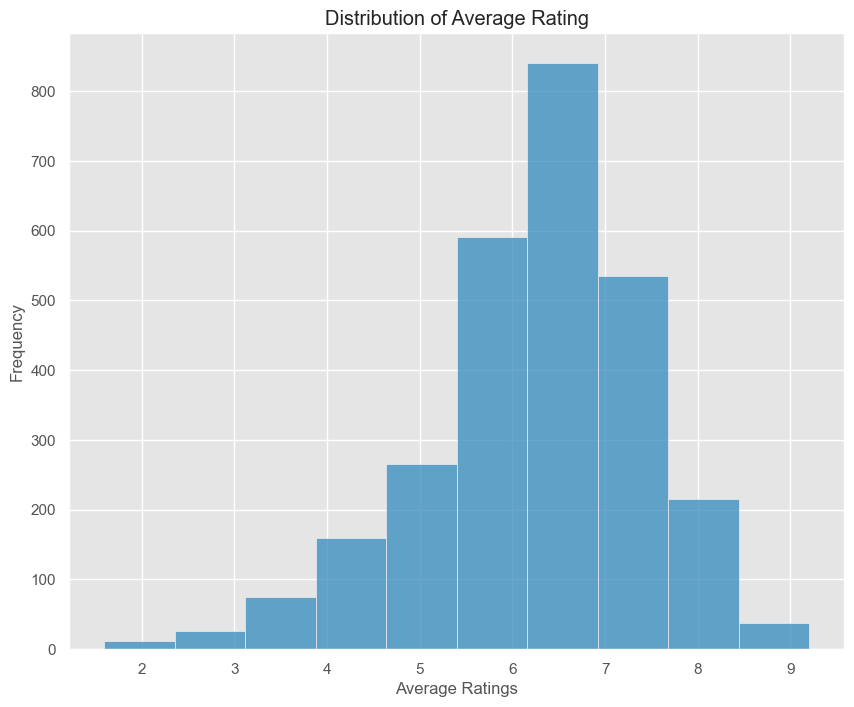

In [2189]:
combined_df['averagerating'] = (pd.to_numeric(combined_df['averagerating'], errors='coerce'))

# Plot to see the Distributio of average ratings of genres in our combined_df DataFrame
plt.figure(figsize = (10, 8))

plt.style.use('ggplot')

sns.histplot(combined_df['averagerating'].squeeze(), bins = 10) # Histogram with 10 bins
plt.title('Distribution of Average Rating')
plt.xlabel('Average Ratings')
plt.ylabel('Frequency')
plt.show()